In [1]:
# Standard libraries
import os
import re
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict, Literal

# Third-party libraries
import cv2
import numpy as np
from PIL import Image, ImageDraw
from itertools import compress
import matplotlib.pyplot as plt

# Local libraries
from utils.annotations import BoundingBox
#from utils.annotations import intersection_over_union, Detection


Load in yolo data

In [2]:
# Load yolo_data.json
PATH_TO_YOLO_DATA = "../data/yolo_data.json"
PATH_TO_REGISTERED_IMAGES = "../data/registered_images"
UNIFIED_IMAGE_PATH = (
    "../data/unified_intraoperative_preoperative_flowsheet_v1_1_front.png"
)

# Load yolo_data.json
with open(PATH_TO_YOLO_DATA) as json_file:
    yolo_data = json.load(json_file)

# See how many intraoperative images are registered
print(f"Found {len(yolo_data)} sheets in yolo_data.json")

# Load the json for the intraoperative document landmarks
PATH_TO_LANDMARKS = "../data/intraop_document_landmarks.json"
with open(PATH_TO_LANDMARKS) as json_file:
    landmark_locations = json.load(json_file)
    print(
        f"Found {len(landmark_locations)} items in intraop_document_landmarks.json"
    )


Found 19 sheets in yolo_data.json
Found 20 items in intraop_document_landmarks.json


Set image width and height constant

In [3]:
DESIRED_IMAGE_WIDTH = 800
DESIRED_IMAGE_HEIGHT = 600

Method to extract bounding box centers from registered images

In [38]:
def select_relevant_bounding_boxes(
    sheet_data: List[str],
    path_to_image: Path,
    show_images: bool = False,
    desired_img_width: int = DESIRED_IMAGE_WIDTH,
    desired_img_height: int = DESIRED_IMAGE_HEIGHT,
) -> Tuple[List[str], List[str]]:
    
    # Load the image
    image = cv2.imread(path_to_image)

    # Display the image and allow the user to select a ROI
    resized_image = cv2.resize(image, (desired_img_width, desired_img_height))

    # convert the YOLO data to Bounding Boxes
    bboxes: List[BoundingBox] = [
        BoundingBox.from_yolo(yolo_bb, desired_img_width, desired_img_height)
        for yolo_bb in sheet_data
    ]

    bounding_boxes_all = []

    # Process the bounding boxes
    for bounding_box in bboxes:
        # get the center point of the bounding box for comparison
        x_center_bb, y_center_bb = bounding_box.center
        bounding_boxes_all.append(bounding_box.center)
    
    if show_images:
        # Display the image with the selected region and bounding boxes
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        resized_image = Image.fromarray(resized_image)
        resized_image.show()

    # return x,y coordinate of bounding box centers
    return bounding_boxes_all


Extract bounding box centers from registered sheets

In [39]:
all_bounding_boxes = []
# Iterate over all images and their bounding boxes
for sheet, yolo_bbs in yolo_data.items():
    # print(f"Sheet: {sheet}")
    full_image_path = os.path.join(PATH_TO_REGISTERED_IMAGES, sheet)
    # print(f"Full image path: {full_image_path}")

    # Call the analyze_sheet function with data from the loop
    sheet_bounding_boxes = select_relevant_bounding_boxes(
        yolo_bbs, full_image_path, show_images=False
    )

    # append boxes for each sheet
    all_bounding_boxes.append(sheet_bounding_boxes)

In [143]:
all_bounding_boxes

[[(727.8792909564394, 228.8513470818015),
  (766.7570430871212, 37.45609059053309),
  (766.6257102272727, 51.51405065199908),
  (766.4500769412879, 65.66600844439338),
  (765.7401160037878, 428.0791877297794),
  (765.8693181818181, 442.57255284926475),
  (765.9528290719697, 455.39697265625),
  (765.9203065814394, 469.11007869944854),
  (766.478397253788, 482.8346019071691),
  (766.288174715909, 496.6002125459559),
  (767.1706616950758, 510.2892061121323),
  (767.566317471591, 524.2528722426471),
  (133.25807883522728, 22.145589491900278),
  (148.08826793323863, 22.235566980698533),
  (160.06120531486744, 22.2857666015625),
  (164.16613399621212, 22.348811430089615),
  (174.51998993844697, 22.363573859719665),
  (178.71150716145834, 22.308144962086395),
  (189.08108428030303, 22.282228357651654),
  (193.49139589251894, 22.26572822122013),
  (203.35397431344697, 22.285052131204043),
  (207.85485469933712, 22.211902394014245),
  (217.79433741714013, 22.23130798339844),
  (222.349542791193

Plot one sheet for reference

Text(0.5, 1.0, 'Detected centers from one sheet')

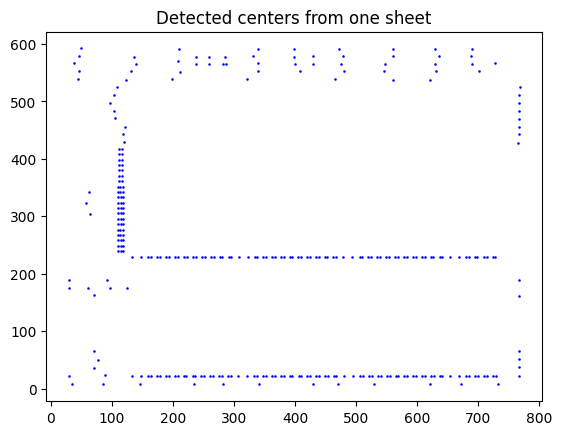

In [87]:
plt.scatter(*zip(*all_bounding_boxes[0]), s=0.7, c='blue')
plt.title('Detected centers from one sheet')

Access the expected centroids

In [33]:
PATH_TO_EXPECTED_CENTROIDS = '../data/intraop_centroids.json'

with open(PATH_TO_YOLO_DATA) as json_centroids:
    centroids = json.load(json_centroids)

Select x, y center values and format

In [80]:
centroids['RC_0001_intraoperative.JPG']
# split on spaces and pick elements 1 and 2
lister = [item.split(' ')[1:3] for item in centroids['RC_0001_intraoperative.JPG']]
# convert string representation to float
centroid_num = []
for i in range(len(lister)):
    centroid_num.append(list(map(float, lister[i])))

Plot one sheet of expected centers

Text(0.5, 1.0, 'Expected centers from one sheet')

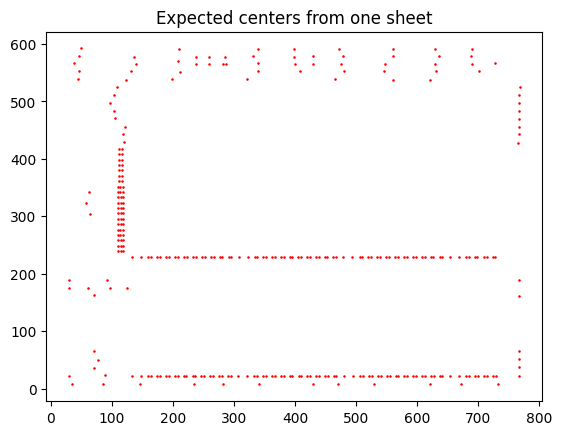

In [ ]:
# unpack a list of pairs into two tuples
x, y = zip(*centroid_num)

# scale to the sheet area
x = [value * DESIRED_IMAGE_WIDTH for value in x]
y = [value * DESIRED_IMAGE_HEIGHT for value in y]

plt.scatter(x, y, s=0.7, c='red')
plt.title('Expected centers from one sheet')

Whoops these look identical

Text(0.5, 1.0, 'Points from intraop_centroids.json and manual registration of images')

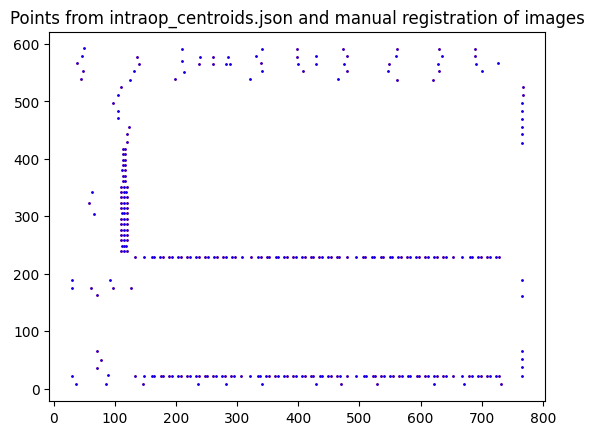

In [142]:
plt.scatter(x, y, s=0.7, c='red')
plt.scatter(*zip(*all_bounding_boxes[0]), s=0.7, c='blue')
plt.title('Points from intraop_centroids.json and manual registration of images')

In [140]:
# landmark_locations[0:19]['annotations'][0]['result'][0:3]['value']['x':'y']
# extract x coordinate from landmarks
x_landmarks = []
for i in range(20):
    for j in range(4):
        x_landmarks.append(landmark_locations[i]['annotations'][0]['result'][j]['value']['x'])

# extract y coordinate from landmarks
y_landmarks = []
for i in range(20):
    for j in range(4):
        y_landmarks.append(landmark_locations[i]['annotations'][0]['result'][j]['value']['y'])
